# Analysis Notebook

In [71]:
import matplotlib
import pandas as pd
import os
import operator

DATAPATH = "../data/clean/bike_accidents.csv"
assert os.path.exists(DATAPATH)

DATA = DATA = pd.read_csv(DATAPATH)


In [73]:
# Adding some useful columns and defining some functions for use later in this notebook.

# New Columns
# Boolean value: True -> Casualty (injury or fatality); False -> Noncasualty
DATA['casualty_indicator'] = DATA['fatality_indicator'] | DATA['injury_indicator']
DATA['noncasualty_indicator'] = ~(DATA['fatality_indicator'] | DATA['injury_indicator'])

# Some roadways have a number but no name. Combine these values into a single column. 
# roadway name if any else roadway number. 
DATA['main_roadway'] = DATA['roadway_name'].combine_first(DATA['roadway_number'])
DATA['intersection_roadway'] = DATA['intersection_roadway_name'].combine_first(DATA['intersection_roadway_number'])

# Boolean value: True -> accident occurred in an intersection / between streets
DATA['intersection_indicator'] = DATA['intersection_roadway'].notnull()
DATA['between_street_indicator'] = (
    DATA['between_street_name_1'].notnull() | DATA['between_street_name_2'].notnull() | 
    DATA['between_street_number_1'].notnull() | DATA['between_street_number_2'].notnull())

#DATA.columns

In [74]:
# Useful function definitions / constants
TOTAL_ACCIDENTS = len(DATA) # Total number of accident reports
DANGERMASK = ['fatality_indicator', 'injury_indicator', 'casualty_indicator', 'noncasualty_indicator' ]
# This will get used over and over to analyse relative frequencies of crash outcomes.

def percent_round(x):
    """Create a readable percentage float using round()"""
    return round(x*100, 2)

def percent_format(x):
    """Format a number as a percentage."""
    return format(x, ".2%")


class DangerReport(pd.DataFrame):
    @property
    def totals(df):
        return df['casualties'] + df['noncasualties']
    
    def get_ratio_by_total(df):
        return (df/TOTAL_ACCIDENTS).apply(percent_round)

    def get_ratio_by_value_total(df):
        #totals = df['casualties'] + df['noncasualties']
        return df.apply(lambda x:x/df.totals).apply(percent_round)
    
    def get_danger_ratios(df):
        """total accidents, percent casualty, percent fatality of casualty"""
        out = pd.DataFrame(index=df.index)
        out['total'] = df.totals
        out['percent casualty'] = out.total.combine(df.casualties, lambda T, C:C/T).apply(percent_round)
        out['pct fatality of casualty'] = df.casualties.combine(df.fatalities, lambda C, F:F/C).apply(percent_round)
        out['pct fatality of total'] = df.fatalities.combine(out.total, lambda F, T:F/T).apply(percent_round)
        return out

def get_danger_report(df, label):
    report = df.groupby(label)[DANGERMASK].sum()
    report = report.rename({"injury_indicator":'injuries', 
                          'fatality_indicator':'fatalities',
                          'casualty_indicator':'casualties',
                          'noncasualty_indicator':'noncasualties'}, axis=1)
    return DangerReport(report)

# There's a way to work this into the class definition but I'd rather not struggle with
# __init__ and __new__ definitions right now. 

# lines for testing.
get_danger_report(DATA, 'weather').get_danger_ratios()

,total,percent casualty,pct fatality of casualty,pct fatality of total
weather,,,,
BLOWING SAND/SOIL/DIRT/SNOW,1,100.00,0.00,0.00
CLEAR,1084,71.86,2.82,2.03
CLOUDY,213,72.30,5.19,3.76
FOG WITH RAIN,1,100.00,100.00,100.00
OTHER,2,50.00,0.00,0.00
RAINING,69,76.81,5.66,4.35
SNOWING,4,75.00,0.00,0.00


## Time of day

The first question I'm curious about is: What time of day is the most dangerous to ride? 

I know, as a cyclist, that it is more dangerous to ride in the dark, but is there any particular time that is more dangerous than others? Is there a time during daylight hours that is more dangerous than others? First, I'll group the data by 'hour' to see what the pattern is.

<Axes: xlabel='hour of day', ylabel='accident count'>

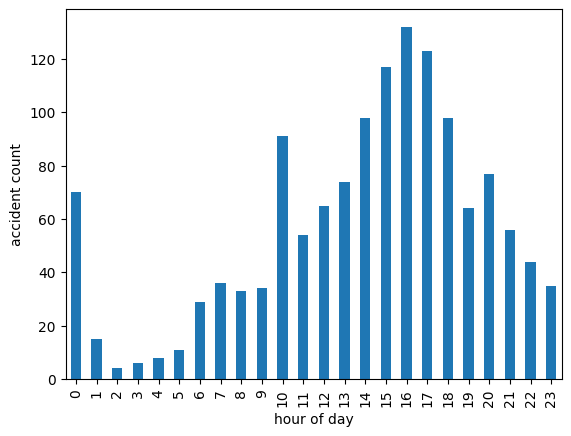

In [75]:

DATA.groupby('hour').size().plot(kind='bar', xlabel='hour of day', ylabel="accident count")

Immediately, I can identify a couple problems here. The huge spike at midnight (hour 0) is suspicious. I suspect that 00:00 is a default time entered when a specific time is not in the accident report, and this is the cause of the irregularity. 

<Axes: xlabel='hour of day', ylabel='count of light_condition == DAYLIGHT'>

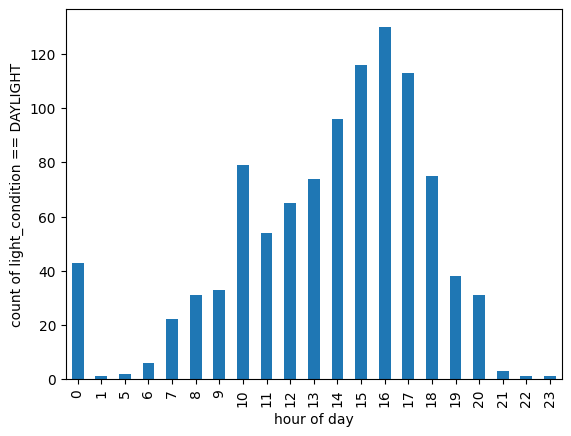

In [76]:
hour_light = DATA[['hour', 'light_condition']]
hour_light[hour_light['light_condition'] == "DAYLIGHT"].groupby('hour').size().plot(
    kind='bar', xlabel='hour of day', ylabel='count of light_condition == DAYLIGHT')

This confirms my suspicions. The above graph shows the number of accidents grouped by hour where light_condition == DAYLIGHT. Since Louisville, KY is well below the Arctic Circle, there is never any light condition at midnight that anyone would consider "daylight". I suspect that "daylight" is also a default value. In any case, these data are not going to be useful to me, so I'll just drop them for my analysis. 

<Axes: xlabel='hour of day', ylabel='DAYLIGHT'>

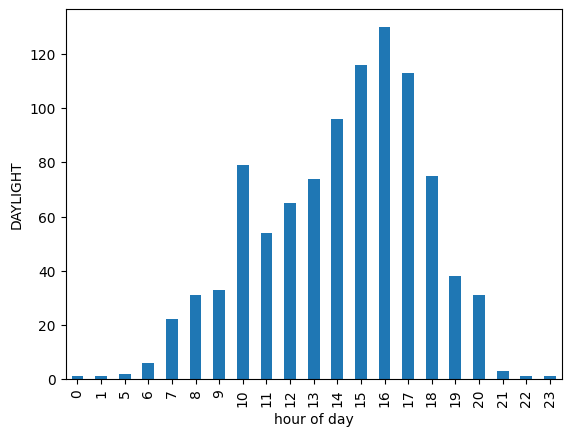

In [77]:
zeros = DATA[(DATA.hour==0) & (DATA.minute==0)]
# Get all rows that have 00:00 time value

#zeros[zeros['date'].apply(lambda x:x.second==0)]
# Check that the seconds are zero too. They are. 

zeros_index = zeros[zeros['light_condition'] == "DAYLIGHT"].index
# For recrods that have 00:00 time, find the ones that have light_condition == DAYLIGHT, 
# then filter these records out of my data:

filtered_light = DATA[~DATA.index.isin(zeros_index)]
# Now let's see what the time distribution for DAYLIGHT condition looks like 
# once we've dropped the default data.

filtered_light[filtered_light['light_condition'] == "DAYLIGHT"].groupby('hour').size().plot(
    kind='bar', ylabel='DAYLIGHT', xlabel='hour of day')

This is much more in line with what I would expect. However, if we return to a plot of all the data, there is another problem I can identify. This is a simple plot of the count of accidents for each hour. We can see that most accidents occur at 4 PM (hour 16). It is totally possible that it's slightly more dangerous to ride at 4 PM, since that is close to rush hour, but it is not likely that riding at midday is more dangerous than riding in the early morning or late at night, when it is dark. 


<Axes: xlabel='hour'>

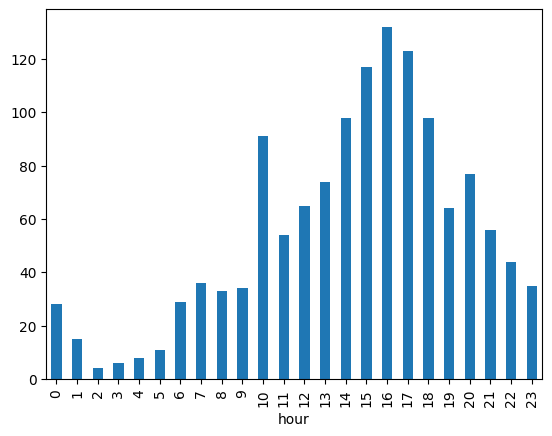

In [78]:
# Plot of all accidents with some outlier data removed.
filtered_light.groupby('hour').size().plot.bar()


The issue is that we don't know how many people are riding in general at these hours. Most cycling accidents occur during the day because that is when most cyclists are on the road. Few people ride at night, so there are less accidents in total, but I know from experience that riding in the dark is more risky. I need to develop a measure of danger that isn't just a naive count of accidents.

The dataset includes information which indicates fatal accidents and accidents resulting in injuries. I'm going to take a look at the relative rates of injuries and fatalities to see if I can tease out any patterns.

<Axes: xlabel='hour'>

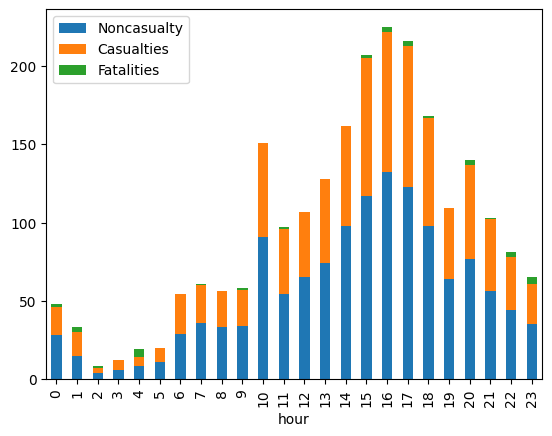

In [79]:
hours = filtered_light.groupby('hour')
totals = hours.size()
total_casualty = hours.casualty_indicator.sum() # Accidents resulting in death or injury
total_fatality = hours.fatality_indicator.sum() # Accidents resulting in death. 

data = pd.DataFrame({'Noncasualty':totals, "Casualties":total_casualty, "Fatalities":total_fatality})
data.plot(kind='bar', stacked=True)

<Axes: xlabel='hour'>

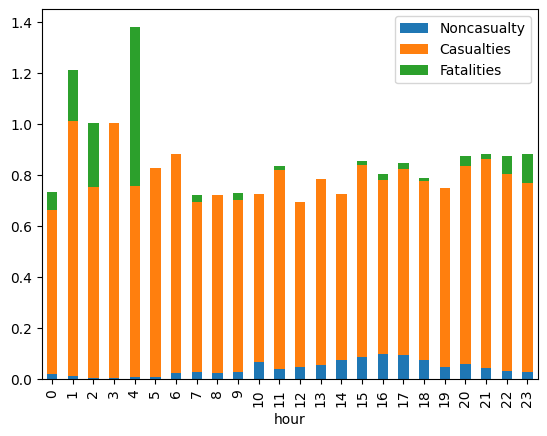

In [80]:
# Interesting, but I'm going to try plotting it by percentages of casualty and fatality per total to see
# if any pattern is clearer.

filtered_light_total = totals.sum()
percent_total = totals / grand_total
percent_casualty = hours.casualty_indicator.sum() / totals
percent_fatality = hours.fatality_indicator.sum() / totals


data = pd.DataFrame({'Noncasualty':percent_total, "Casualties":percent_casualty, "Fatalities":percent_fatality})
data.plot(kind='bar', stacked=True)

This is a little more clear. We can see that the percent of accidents which do not result in injury or death (Noncasualties) increases during daylight hours. On the other hand, during dark hours (8 PM to 4 AM (20 to 23 and 0 to 4), for example the rate of noncasualty accidents is very low, and the portion of accidents that result in a fatality is much higher. 

In particular, the small hours of the morning, 1 AM to 4 AM look very dangerous. 2AM and 3 AM are almost all casualties!

The relationship is still messy. Rather than grouping by hour, I want to try a less granular mode of analysis. The data contains a field called "light_condition" which I will summarize below. 

In [81]:
filtered_light.light_condition.value_counts()

light_condition
DAYLIGHT                           972
DARK-HWY LIGHTED/ON                175
DARK-HWY NOT LIGHTED                62
DUSK                                58
DAWN                                31
DARK-HWY LIGHTED/OFF                26
DARK (UNKNOWN ROADWAY LIGHTING)      7
OTHER                                1
Name: count, dtype: int64

In [82]:
# A few of these values have more to do with the road lighting conditions than the time of day.
# I'm going to see if I can clean that up.

# Let's show which hours correspond to each light_condition:

filtered_light.groupby('light_condition').hour.unique().apply(lambda x:sorted(x))


light_condition
DARK (UNKNOWN ROADWAY LIGHTING)                                       [0, 5, 19, 20]
DARK-HWY LIGHTED/OFF                        [0, 1, 6, 7, 10, 18, 19, 20, 21, 22, 23]
DARK-HWY LIGHTED/ON                [0, 1, 2, 3, 4, 5, 6, 7, 10, 18, 19, 20, 21, 2...
DARK-HWY NOT LIGHTED               [0, 1, 2, 3, 4, 5, 6, 17, 18, 19, 20, 21, 22, 23]
DAWN                                 [0, 6, 7, 8, 9, 14, 15, 16, 17, 18, 19, 21, 22]
DAYLIGHT                           [0, 1, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...
DUSK                                      [0, 7, 10, 16, 17, 18, 19, 20, 21, 22, 23]
OTHER                                                                           [22]
Name: hour, dtype: object

That's a bit of a mess. It looks like the values for light condition aren't really set in any way that makes intuitive sense. Values like DARK-HWY NOT LIGHTED and DARK-HWY etc. seem to indicate roadway lighting more than any kind of time-of-day related light condition. I think I will just write a grouping function that sorts these in terms that make sense based on the hour of day.

<Axes: >

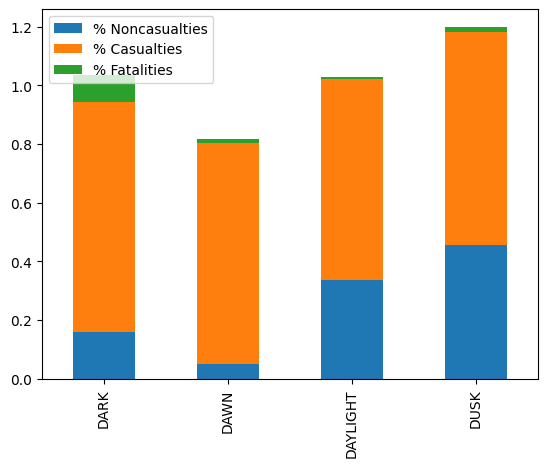

In [87]:
def light_grouper(df, location):
    row = df.loc[location]
    light_condition = row.light_condition
    hour = row.hour
    if light_condition in ("OTHER", "DARK (UNKNOWN ROADWAY LIGHTING)"):
        return "DARK" 
        # These light_condition values do seem to indicate dark hours for this data. Easy enough.
    else: # Group hours into DAWN, DAYLIGHT, DUSK, DARK
        # I could get more precise with this, relating the time of year and average sunset/sunrise time,
        # but for ease of summary I will just do something simpler that works.
        if 6 <= hour < 8:
            return "DAWN"
        elif 15 <= hour <= 20:
            return "DUSK"
        elif (hour > 20) or (hour < 6):
            return "DARK"
        else:
            return "DAYLIGHT"


# Now I'll do the same types of plots that I did by `hour` above.

light_group = filtered_light.groupby(by=lambda x:light_grouper(filtered_light, x))
totals = light_group.size()
percent_casualties = light_group.casualty_indicator.sum() / totals
percent_fatalities = light_group.fatality_indicator.sum() / totals
percent_total = totals / totals.sum()

data = pd.DataFrame({"% Noncasualties":percent_total, "% Casualties":percent_casualties, "% Fatalities":percent_fatalities})
data.plot(kind='bar', stacked=True)

We can see that many more fatalities occur during dark hours. We can also see that more accidents in general occur during the evening or dusk. This isn't actually very interesting to me, because I already knew that it is more dangerous to ride in the dark, but it does show me that this method of analysis will work to find which types of accidents are relatively more dangerous. 

Let's take a look at a part of the data which shouldn't be affected by the same sampling issue we've encountered grouping by time of day.

# Intersections, Traffic Signals, and Midstreet Accidents

My hypothesis regarding these conditions is that there is no bias regarding whether cyclists decide to travel through intersections or not, intersections with traffic signals or not. In other words, if you want to ride on roads, you basically can't avoid riding through an intersection at some point. Very few people are likely to ride up and down a street without ever doing this. So, it should be easy to determine the relative danger between these areas.

<Axes: >

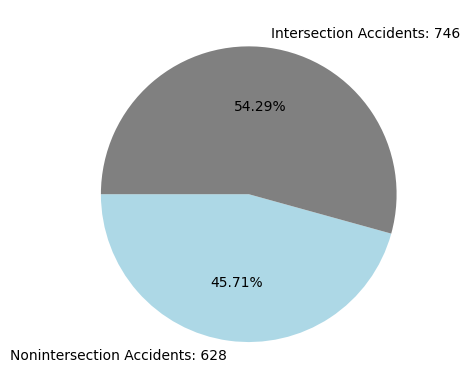

In [89]:
# First I want to see if more accidents occur in intersections or midstreet.

report = get_danger_report(DATA, 'intersection_indicator')
totals = report.casualties + report.noncasualties
report['total'] = totals
labels = [f"Nonintersection Accidents: {totals[False]}", f"Intersection Accidents: {totals[True]}"]
totals.plot.pie(labels=labels, autopct='%.2f%%', startangle=180, colors = ['lightblue', 'grey'])



That makes sense. My intuition is that intersections are more dangerous because there is cross traffic and therefore more opportunities for someone to get hit. Let's take a look at the portion of accidents which occur in intersections which have lighted traffic signals:


<Axes: >

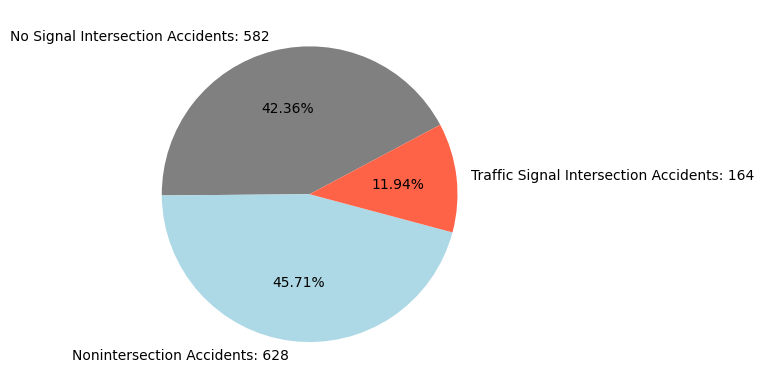

In [90]:

def crash_site_grouper(df, location):
    row = df.loc[location]
    if row.intersection_indicator == True:
        if row.lighted_signal_indicator == True:
            return 'Traffic Light'
        else:
            return 'Intersection'
    else:
        return 'Nonintersection'
    

site_report = pd.DataFrame(DATA.groupby(by=lambda x:crash_site_grouper(DATA, x))[DANGERMASK].sum())
totals = site_report.casualty_indicator + site_report.noncasualty_indicator
totals = totals.rename({"Traffic Light":"Traffic Signal Intersection Accidents",
               "Intersection": "No Signal Intersection Accidents",
               "Nonintersection":"Nonintersection Accidents"})
totals.plot.pie(autopct="%.2f%%", ylabel='', startangle=28, 
                colors=['grey', 'lightblue', 'tomato'], 
                #hatch=['', '', 'ooo'],
        labels=["{key}: {value}".format(key=key, value=value) for key, value in totals.to_dict().items()])

That is pretty interesting. Dramatically fewer accidents happen in an intersection when there is a traffic light. When we factor that in, it almost looks like midstreet accidents, which I've labelled as Nonintersection accidents here, are more dangerous than intersections without traffic lights!

In [19]:
# Most dangerous roads?

#top_most_dangerous_roads = 
# Group by road type?
# Find percents by this: what percent of accidents occur in these most dangerous roads.
#top_most_dangerous_roads.plot(kind='bar', ylabel='value count')



<Axes: xlabel='main_roadway'>

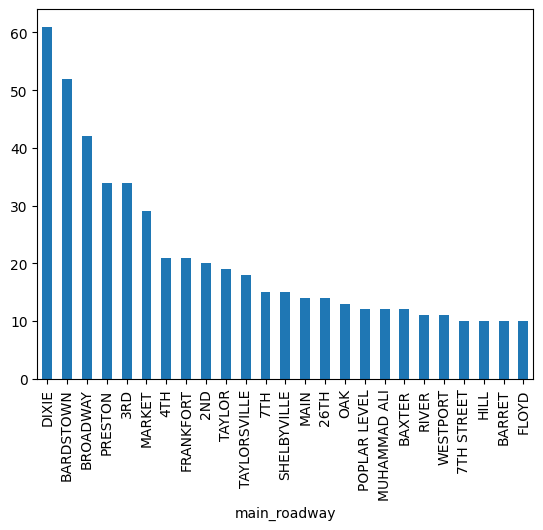

In [20]:
roadwaygroup = DATA.groupby(['main_roadway'])

roadwaygroup.size().sort_values(ascending=False).head(25).plot.bar()

In [21]:
roadwaygroup[DANGERMASK].sum().sort_values(by=['casualty_indicator'], ascending=False).head(25)

,fatality_indicator,injury_indicator,casualty_indicator,noncasualty_indicator
main_roadway,,,,
DIXIE,2,51,53,8
BROADWAY,0,30,30,12
BARDSTOWN,2,26,28,24
PRESTON,3,24,27,7
MARKET,0,19,19,10
TAYLORSVILLE,0,18,18,0
3RD,0,18,18,16
4TH,0,17,17,4
2ND,0,14,14,6


,% casualty,% fatality,% all accidents
intersection_indicator,,,
False,70.86,4.30,45.71
True,73.32,0.94,54.29


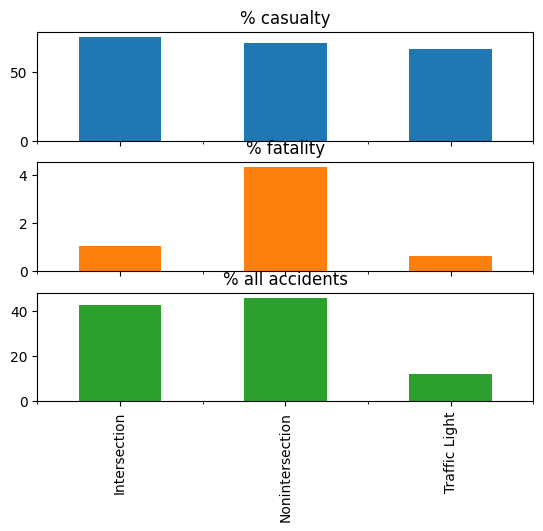

In [24]:
site_report['total'] = site_report.casualty_indicator + site_report.noncasualty_indicator
site_report['% casualty'] = (site_report.casualty_indicator / site_report.total).apply(percent_round)
site_report['% fatality'] = (site_report.fatality_indicator/ site_report.total).apply(percent_round)
site_report['% all accidents'] = (site_report.total / TOTAL_ACCIDENTS).apply(percent_round)
site_report.iloc[:,-3:].plot.bar(subplots=True, legend=False)
report['% casualty'] = (report.casualties/ report.total).apply(percent_round)
report['% fatality'] = (report.fatalities/ report.total).apply(percent_round)
report['% all accidents'] = (report.total / TOTAL_ACCIDENTS).apply(percent_round)
report.iloc[:,-3:]

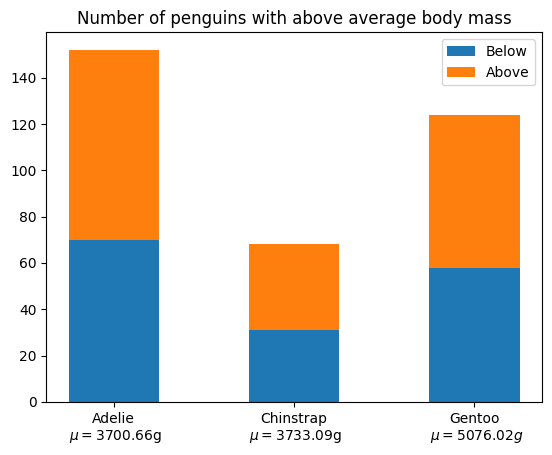

In [25]:
import matplotlib.pyplot as plt
import numpy as np

species = (
    "Adelie\n $\\mu=$3700.66g",
    "Chinstrap\n $\\mu=$3733.09g",
    "Gentoo\n $\\mu=5076.02g$",
)
weight_counts = {
    "Below": np.array([70, 31, 58]),
    "Above": np.array([82, 37, 66]),
}
width = 0.5

fig, ax = plt.subplots()
bottom = np.zeros(3)

for boolean, weight_count in weight_counts.items():
    p = ax.bar(species, weight_count, width, label=boolean, bottom=bottom)
    bottom += weight_count

ax.set_title("Number of penguins with above average body mass")
ax.legend(loc="upper right")

plt.show()